In [1]:
import os
import numpy as np
import torch
import torchvision
import random

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


### DataLoading and augmentations

In [2]:
from torchvision import datasets
from torch.utils.data import SubsetRandomSampler
from torchvision.transforms import v2
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

preprocess = EfficientNet_V2_S_Weights.DEFAULT.transforms()

train_transforms = v2.Compose([
    v2.TrivialAugmentWide(),
    v2.RandomErasing(0.1),
    preprocess
])

test_transforms = v2.Compose([
    preprocess
])


data_dir = '/content/train/simpsons_dataset'
train_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(data_dir, transform=test_transforms)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

test_size = 0.05
split = int(np.floor(test_size * num_train))

train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)





In [3]:
from torch.utils.data import default_collate

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

cutmix = v2.CutMix(num_classes=len(train_dataset.classes))
mixup = v2.MixUp(num_classes=len(train_dataset.classes))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])



train_loader = torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=32, num_workers=os.cpu_count(), pin_memory=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

### id2label and image showing

In [4]:
string_labels = train_dataset.classes
label_to_string = {num: string for num, string in enumerate(string_labels)}

In [5]:
import matplotlib.pyplot as plt
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.title(title)


### Model initialisation and layer freezing

In [7]:
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

for p in model.parameters():
    p.requires_grad = False

In [9]:
model.classifier[1] = torch.nn.Linear(1280, len(string_labels))

for p in model.features[-2:].parameters():
    p.requires_grad = True

In [10]:
_ = summary(model, (3,480,480))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 15, 15]        --
|    └─Conv2dNormActivation: 2-1              [-1, 24, 240, 240]        --
|    |    └─Conv2d: 3-1                       [-1, 24, 240, 240]        (648)
|    |    └─BatchNorm2d: 3-2                  [-1, 24, 240, 240]        (48)
|    |    └─SiLU: 3-3                         [-1, 24, 240, 240]        --
|    └─Sequential: 2-2                        [-1, 24, 240, 240]        --
|    |    └─FusedMBConv: 3-4                  [-1, 24, 240, 240]        (5,232)
|    |    └─FusedMBConv: 3-5                  [-1, 24, 240, 240]        (5,232)
|    └─Sequential: 2-3                        [-1, 48, 120, 120]        --
|    |    └─FusedMBConv: 3-6                  [-1, 48, 120, 120]        (25,632)
|    |    └─FusedMBConv: 3-7                  [-1, 48, 120, 120]        (92,640)
|    |    └─FusedMBConv: 3-8                  [-1, 48, 120, 120]    

In [11]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### Class weights for imbalanced data

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# import torch


# y_train = np.array(train_dataset.targets)


# class_weights = compute_class_weight( class_weight= 'balanced', classes=np.unique(y_train), y=y_train)
# print(class_weights)
# class_weights = np.log(class_weights + 1)
# print(class_weights)
# class_weights = torch.tensor(class_weights, dtype=torch.float, device='cuda')

### Model training

In [12]:

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
unfrozen_parameters = filter(lambda p: p.requires_grad, model.parameters())
optim = torch.optim.AdamW(unfrozen_parameters, lr = 2e-4, weight_decay=5e-5)

scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.97)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=4)

In [13]:
from sklearn.metrics import f1_score

EPOCHS = 300

train_losses = []
val_losses = []

In [14]:
for epoch in range(1, EPOCHS):

    train_total_loss = 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)


        optim.zero_grad(set_to_none=True)

        pred_logits = model(X_train)
        train_loss = loss_fn(pred_logits, y_train)

        train_loss.backward()
        optim.step()

        train_total_loss += train_loss

        if batch % 50 == 0:
            print(f"epoch_{epoch} batch_{batch} trained")



    train_total_loss /= len(train_loader)
    train_losses.append(train_total_loss.item())

    model.eval()

    val_total_loss = 0
    val_total_f1 = 0


    with torch.inference_mode():
        for batch, (X_val, y_val) in enumerate(test_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)

            val_pred_logits = model(X_val)
            val_total_loss += loss_fn(val_pred_logits, y_val)
            val_total_f1 += f1_score(y_val.cpu(), val_pred_logits.argmax(-1).cpu(), average="micro")



        val_total_loss /= len(test_loader)
        val_total_f1 /= len(test_loader)

        val_losses.append(val_total_loss.item())


    print(f"epoch_{epoch}:   train loss = {train_total_loss:.5f},   val loss = {val_total_loss:.5f}, val f1 = {val_total_f1:.5f}, lr = {optim.param_groups[0]['lr']:.10f}")


    scheduler.step(val_total_loss)
    scheduler1.step()

    torch.save({
        "model": model.state_dict(),
        "optim": optim.state_dict(),
        "losses": {"train_losses":train_losses, "val_losses": val_losses},
        "random_states": {"python_rng_state": random.getstate(),
                          "np_rng_state": np.random.get_state(),
                          "torch_rng_state": torch.get_rng_state(),
                          "cuda_rng_state": torch.cuda.get_rng_state(),
                          },
        "scheduler": [scheduler.state_dict(), scheduler1.state_dict()]

    },
        f"/content/drive/MyDrive/DLS/checkpoints/epoch_{epoch}.pt")




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_1 batch_0 trained
epoch_1 batch_50 trained
epoch_1 batch_100 trained
epoch_1 batch_150 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_1:   train loss = 2.34885,   val loss = 1.02956, val f1 = 0.91990, lr = 0.0002000000


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_2 batch_0 trained
epoch_2 batch_50 trained
epoch_2 batch_100 trained
epoch_2 batch_150 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_2:   train loss = 1.68215,   val loss = 0.88854, val f1 = 0.96717, lr = 0.0001940000


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_3 batch_0 trained
epoch_3 batch_50 trained
epoch_3 batch_100 trained
epoch_3 batch_150 trained
epoch_3:   train loss = 1.67477,   val loss = 0.90147, val f1 = 0.97064, lr = 0.0001881800


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_4 batch_0 trained
epoch_4 batch_50 trained
epoch_4 batch_100 trained
epoch_4 batch_150 trained
epoch_4:   train loss = 1.60719,   val loss = 0.91371, val f1 = 0.98438, lr = 0.0001825346


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_5 batch_0 trained
epoch_5 batch_50 trained
epoch_5 batch_100 trained
epoch_5 batch_150 trained
epoch_5:   train loss = 1.54206,   val loss = 0.88652, val f1 = 0.98438, lr = 0.0001770586


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_6 batch_0 trained
epoch_6 batch_50 trained
epoch_6 batch_100 trained
epoch_6 batch_150 trained
epoch_6:   train loss = 1.50241,   val loss = 0.85675, val f1 = 0.98785, lr = 0.0001717468


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_7 batch_0 trained
epoch_7 batch_50 trained
epoch_7 batch_100 trained
epoch_7 batch_150 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_7:   train loss = 1.43869,   val loss = 0.81334, val f1 = 0.98958, lr = 0.0001665944


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_8 batch_0 trained
epoch_8 batch_50 trained
epoch_8 batch_100 trained
epoch_8 batch_150 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_8:   train loss = 1.44245,   val loss = 0.85056, val f1 = 0.99132, lr = 0.0001615966


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_9 batch_0 trained
epoch_9 batch_50 trained
epoch_9 batch_100 trained
epoch_9 batch_150 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_9:   train loss = 1.46189,   val loss = 0.80453, val f1 = 0.99306, lr = 0.0001567487


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_10 batch_0 trained
epoch_10 batch_50 trained
epoch_10 batch_100 trained
epoch_10 batch_150 trained
epoch_10:   train loss = 1.43601,   val loss = 0.84545, val f1 = 0.99306, lr = 0.0001520462


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_11 batch_0 trained
epoch_11 batch_50 trained
epoch_11 batch_100 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

### Resuming of training or unfreezeing additional layers

In [35]:
checkpoint = torch.load("/content/drive/MyDrive/DLS/checkpoints/epoch_18.pt")

model.load_state_dict(checkpoint['model'])
optim.load_state_dict(checkpoint['optim'])

scheduler.load_state_dict(checkpoint['scheduler'][0])
scheduler1.load_state_dict(checkpoint['scheduler'][1])

train_losses = checkpoint['losses']["train_losses"]
val_losses = checkpoint['losses']["val_losses"]

random.setstate(checkpoint['random_states']['python_rng_state'])
np.random.set_state(checkpoint['random_states']['np_rng_state'])
torch.set_rng_state(checkpoint['random_states']['torch_rng_state'])
torch.cuda.set_rng_state(checkpoint['random_states']['cuda_rng_state'])

In [15]:
for p in model.parameters():
    p.requires_grad = True

In [16]:

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
unfrozen_parameters = filter(lambda p: p.requires_grad, model.parameters())
optim = torch.optim.AdamW(unfrozen_parameters, lr = 5e-6, weight_decay=5e-5)

scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.96)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=3)

In [36]:
for epoch in range(19, EPOCHS):

    train_total_loss = 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)


        optim.zero_grad(set_to_none=True)

        pred_logits = model(X_train)
        train_loss = loss_fn(pred_logits, y_train)

        train_loss.backward()
        optim.step()

        train_total_loss += train_loss

        if batch % 50 == 0:
            print(f"epoch_{epoch} batch_{batch} trained")



    train_total_loss /= len(train_loader)
    train_losses.append(train_total_loss.item())

    model.eval()

    val_total_loss = 0
    val_total_f1 = 0


    with torch.inference_mode():
        for batch, (X_val, y_val) in enumerate(test_loader):
            X_val, y_val = X_val.to(device), y_val.to(device)

            val_pred_logits = model(X_val)
            val_total_loss += loss_fn(val_pred_logits, y_val)
            val_total_f1 += f1_score(y_val.cpu(), val_pred_logits.argmax(-1).cpu(), average="micro")



        val_total_loss /= len(test_loader)
        val_total_f1 /= len(test_loader)

        val_losses.append(val_total_loss.item())


    print(f"epoch_{epoch}:   train loss = {train_total_loss:.5f},   val loss = {val_total_loss:.5f}, val f1 = {val_total_f1:.5f}, lr = {optim.param_groups[0]['lr']:.10f}")


    scheduler.step(val_total_loss)
    scheduler1.step()

    torch.save({
        "model": model.state_dict(),
        "optim": optim.state_dict(),
        "losses": {"train_losses":train_losses, "val_losses": val_losses},
        "random_states": {"python_rng_state": random.getstate(),
                          "np_rng_state": np.random.get_state(),
                          "torch_rng_state": torch.get_rng_state(),
                          "cuda_rng_state": torch.cuda.get_rng_state(),
                          },
        "scheduler": [scheduler.state_dict(), scheduler1.state_dict()]

    },
        f"/content/drive/MyDrive/DLS/checkpoints/epoch_{epoch}.pt")




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch_19 batch_0 trained
epoch_19 batch_50 trained
epoch_19 batch_100 trained
epoch_19 batch_150 trained
epoch_19 batch_200 trained


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

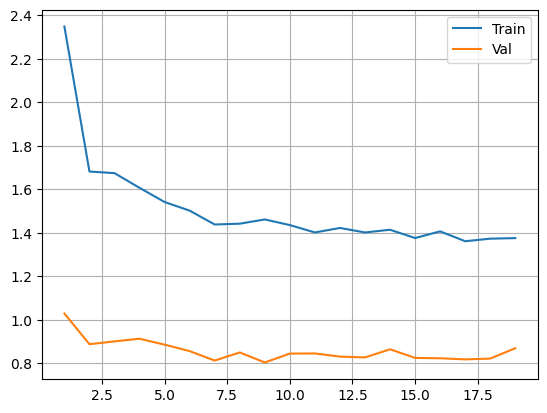

In [17]:
x = list(range(1,len(train_losses)+1))
plt.plot(x, train_losses, label = 'Train')
plt.plot(x, val_losses, label='Val')
plt.legend()
plt.grid('true')

### Testing

In [28]:
test_root = '/content/testset/'

test_set = datasets.ImageFolder(test_root, transform=test_transforms)
dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [29]:

ans = []
model.eval()
with torch.inference_mode():
    for X,y in dataloader:
        preds = model(X.to(device)).argmax(-1)
        ans += preds.tolist()


In [30]:
import pandas as pd
my_submit= pd.read_csv("/content/sample_submission.csv")

In [31]:
ans = list(map(lambda x: label_to_string[x], ans))
ans

['nelson_muntz',
 'bart_simpson',
 'ned_flanders',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'edna_krabappel',
 'chief_wiggum',
 'lisa_simpson',
 'kent_brockman',
 'lenny_leonard',
 'marge_simpson',
 'kent_brockman',
 'ned_flanders',
 'moe_szyslak',
 'comic_book_guy',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'kent_brockman',
 'lisa_simpson',
 'marge_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'mayor_quimby',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'krusty_the_clown',
 'krusty_the_clown',
 'ned_flanders',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'ned_flanders',
 'marge_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'sideshow_bob',
 'lisa_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'kent_brockman',
 'abraham_grampa_simpson',
 'milhouse_van_houten',
 'lenny_leonard',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'chief_wiggum',
 'nelson_muntz',
 'mayor_quimby',
 'c

In [32]:
my_submit['Id'] = my_submit['Id'].sort_values().values
my_submit

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img10.jpg,bart_simpson
3,img100.jpg,bart_simpson
4,img101.jpg,bart_simpson
...,...,...
986,img987.jpg,bart_simpson
987,img988.jpg,bart_simpson
988,img989.jpg,bart_simpson
989,img99.jpg,bart_simpson


In [33]:
my_submit['Expected'] = ans

In [25]:
my_submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [34]:
my_submit.to_csv("my_submit2.csv", index=False)

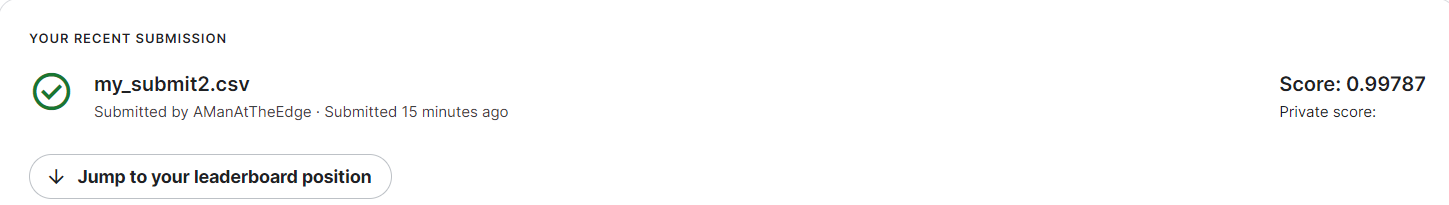

### More epochs and bigger model might give improvements, but i dont want to spend more time for this....